# PCR

In this section, we use Principal Components Analysis to improve logistic regression.

## Data Cleaning

Read in data

Info on variables:
- `slope_of_peak_exercise_st_segment` (type: `int`): the slope of the peak exercise ST segment, an electrocardiography read out indicating quality of blood flow to the heart
- `thal` (type: `categorical`): results of thallium stress test measuring blood flow to the heart, with possible values normal, fixed_defect, reversible_defect
- `resting_blood_pressure` (type: `int`): resting blood pressure
- `chest_pain_type` (type: `int`): chest pain type (4 values)
- `num_major_vessels` (type: `int`): number of major vessels (0-3) colored by flourosopy
- `fasting_blood_sugar_gt_120_mg_per_dl` (type: `binary`): fasting blood sugar > 120 mg/dl
- `resting_ekg_results` (type: `int`): resting electrocardiographic results (values 0,1,2)
- `serum_cholesterol_mg_per_dl` (type: `int`): serum cholestoral in mg/dl
- `oldpeak_eq_st_depression` (type: `float`): oldpeak = ST depression induced by exercise relative to rest, a measure of abnormality in electrocardiograms
- `sex` (type: `binary`): 0: female, 1: male
- `age` (type: `int`): age in years
- `max_heart_rate_achieved` (type: `int`): maximum heart rate achieved (beats per minute)
- `exercise_induced_angina` (type: `binary`): exercise-induced chest pain (0: False, 1: True)

In [1]:
# Importing the necessary librariers 
import pandas as pd
import numpy as np
import thinkstats2
import thinkplot
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.preprocessing import scale # center to the mean and component wise scale to unit variance.
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import sklearn.pipeline as skpl # convenient module for calculating PCs and using them in logistic regression
from sklearn.utils import shuffle

In [2]:
train_values = pd.read_csv('data/train_values.csv')
train_values.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


In [3]:
train_labels = pd.read_csv('data/train_labels.csv')
train_labels.head()

,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


Merge the two dfs

In [4]:
train = pd.merge(train_values, train_labels, on="patient_id")
train.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


Set index to `patient_id`

In [5]:
train = train.set_index('patient_id')
train.head()

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
patient_id,,,,,,,,,,,,,,
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


Replace `thal` values with numbers. 
- `normal`: 0
- `fixed_defect`: 1
- `reversible_defect`: 2

In [6]:
train['thal'] = train['thal'].replace('normal', 0)
train['thal'] = train['thal'].replace('fixed_defect', 1)
train['thal'] = train['thal'].replace('reversible_defect', 2)

In [7]:
y = train['heart_disease_present']
x = train.drop('heart_disease_present', axis=1)

We list out the categorical variables and dummy variables (those that aren't binary) and then standardize the data (excluding the categorical variables) by subtracting the mean and dividing by the standard deviation. We want to standardize the data because some variables have values below 10, while others have values above 100.

In [8]:
categorical_vars= ['thal', 'chest_pain_type', 'sex', 'fasting_blood_sugar_gt_120_mg_per_dl', 'exercise_induced_angina']
dummy_vars = ['thal', 'chest_pain_type']
for col in x.columns:
    if col not in categorical_vars:
        mean = x[col].mean()
        std = x[col].std()
        x[col] = (x[col] - mean)/std

We conduct one-hot encoding of the categorical data and drop the first column to prevent linear dependence/collinearity.

In [9]:
x = pd.get_dummies(x, columns=dummy_vars, drop_first=True)
x = scale(x, 1).astype(float)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  


Helper function that runs PCR with certain number of principal components used. 

In [10]:
def PCR(X, y, num_pcs=16, test_size=0.2):
    # Apply to training data

    # Split into training and test sets (80-20 split)
    # Random state?!
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True)

    # Perform PCA on training data to evaluate test set performance
    pca_train = PCA()
    
    Z_train = pca_train.fit_transform(scale(X_train))
    n = len(Z_train)

    # Go through number of PCs used
    max_accuracy = (0, 0)
    for i in np.arange(1, (num_pcs+1)):
        Z_train_reduced = Z_train[:,:i]
        Z_test_reduced = pca_train.transform(scale(X_test))[:,:i]
        # Train regression model on training data
        regr = LogisticRegression(solver='lbfgs')
        regr.fit(Z_train_reduced, y_train)

        # Predict the labels of the test set: y_pred
        y_pred = regr.predict(Z_test_reduced)
        
        temp_accuracy = accuracy_score(y_test, y_pred)
        
        if temp_accuracy > max_accuracy[1]:
            max_accuracy = (i, temp_accuracy)
    return max_accuracy

Run PCR 1000 times with data shuffling.

In [11]:
iters = 1000
pcs = []
accuracies = []
for i in range(iters):
    pc, accuracy = PCR(x, y, num_pcs=16)
    pcs.append(pc)
    accuracies.append(accuracy)

Plot results

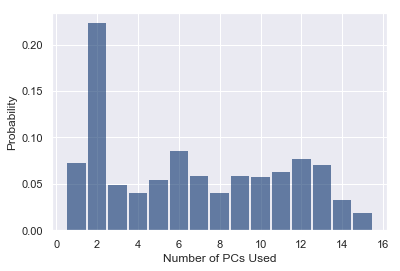

In [12]:
pmf = thinkstats2.Pmf(pcs)
thinkplot.Hist(pmf)
thinkplot.Config(xlabel='Number of PCs Used', ylabel='Probability')

Seems like 2 PCs tend to give the highest accuracies. 

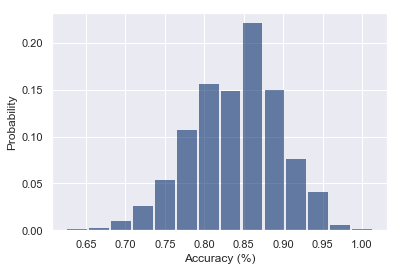

In [13]:
pmf = thinkstats2.Pmf(accuracies)
thinkplot.Hist(pmf)
thinkplot.Config(xlabel='Accuracy (%)', ylabel='Probability')

Accuracies appear skewed to left with a peak at around 85%. 

Graph accuracies of 2 PCs

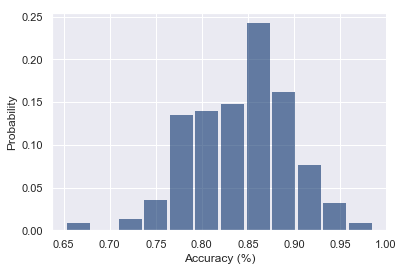

In [14]:
accuracies_2pc = []
for i, pc in enumerate(pcs):
    if pc == 2:
        accuracies_2pc.append(accuracies[i])

pmf = thinkstats2.Pmf(accuracies_2pc)
thinkplot.Hist(pmf)
thinkplot.Config(xlabel='Accuracy (%)', ylabel='Probability')

Accuracy when using two principal components tends to be around 83%. 

Run 1000 iterations using 2 PCs and plot accuracies.

In [15]:
iters = 1000
accuracies_2pc = []
for i in range(iters):
    pc, accuracy = PCR(x, y, num_pcs=2)
    accuracies_2pc.append(accuracy)

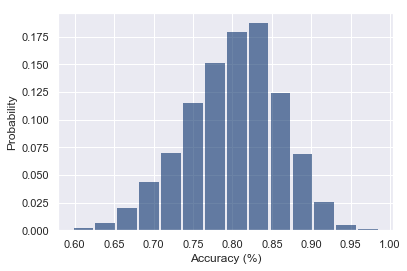

In [16]:
pmf = thinkstats2.Pmf(accuracies_2pc)
thinkplot.Hist(pmf)
thinkplot.Config(xlabel='Accuracy (%)', ylabel='Probability')

PCR doesn't actually improve Logistic Regression very much. This is possibly due to the fact that there are only 13 features. Also, many of the features are categorical, which makes dimensional reduction more limiting. Lastly, the variables are not very correlated with each other, so there is less multicollinearity.   